# Deploying Predictive Systems

Building models that can make predictions was hard work. We had to extract the features of our training data from our raw data, vectorize those features, combine those vectors, create an experiment, and then train, test, and evaluate a statistical model. Fun stuff, but a lot of work!

At this point, it is important to understand that most predictions never make it out of the lab. This point is as far as they ever get. Nobody ever sees them on a website or even indirectly feels their output in any way. Most predictions die in the laboratory where they were created, and a big reason is that the people who build them don’t know how to deploy them. Deploying predictions is our topic in this chapter, and for the aforementioned reason it is an essential one for a practicing data scientist to master.

## Preparing for Predictions

One feature of our model is the distance between `Origin` and `Dest` airports. We need to create an API to get this distance for our web controller that will create predicton requests. This means we must define an API along with its data: `predict_utils.get_flight_distance`.

### Filling in the `predict_utils` API

This means we need a function in `predict_utils.py` called `get_flight_distance(origin, dest)` that returns the flight distance for each pair of airports. To implement this, let’s use PySpark to create a table in MongoDB containing the distance in miles keyed by the origin and destination airport codes. Check out [ch08/origin_dest_distances.py](origin_dest_distances.py). We run a simple `GROUP BY`/`AVG` query to compute the distances between airports:

In [6]:
# Initialize PySpark
APP_NAME = "Introducing PySpark"

# If there is no SparkSession, create the environment
try:
  sc and spark
except NameError as e:
  import findspark
  findspark.init()
  import pyspark
  import pyspark.sql

  sc = pyspark.SparkContext()
  spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initialized...")

PySpark initialized...


In [8]:
import sys, os, re

# Load the on-time Parquet file
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')
on_time_dataframe.registerTempTable("on_time_performance")

origin_dest_distances = spark.sql("""
  SELECT Origin, Dest, AVG(Distance) AS Distance
  FROM on_time_performance
  GROUP BY Origin, Dest
  ORDER BY Distance
""")
origin_dest_distances.repartition(1).write.mode("overwrite").json("../data/origin_dest_distances.json")
os.system("cat ../data/origin_dest_distances.json/part* >> ../data/origin_dest_distances.jsonl")

0

And to load them into MongoDB we run an import of the resulting JSON Lines file. Check out [ch08/import_distances.sh](import_distances.sh), which also creates an index on the `Origin`/`Dest` key:

In [12]:
%%bash

# Import our enriched airline data as the 'airlines' collection
mongoimport -d agile_data_science -c origin_dest_distances --file ../data/origin_dest_distances.jsonl
mongo agile_data_science --quiet --eval 'db.origin_dest_distances.ensureIndex({Origin: 1, Dest: 1})'

{
	"createdCollectionAutomatically" : false,
	"numIndexesBefore" : 1,
	"numIndexesAfter" : 2,
	"ok" : 1
}


2018-05-03T12:30:29.978+0000	connected to: localhost
2018-05-03T12:30:30.203+0000	imported 4696 documents


Let’s verify our data is in Mongo:

In [13]:
%%bash

mongo agile_data_science --quiet --eval 'db.origin_dest_distances.find({"Origin": "ATL", "Dest": "JFK"})'

{ "_id" : ObjectId("5aeb00e6c11f972f229bd60e"), "Origin" : "ATL", "Dest" : "JFK", "Distance" : 760 }


Finally, in [ch08/web/predict_utils.py](web/predict_utils.py), we turn this into an API, `predict_utils.get_flight_distance`, that uses PyMongo:

```python
def get_flight_distance(client, origin, dest):
  """Get the distance between a pair of airport codes"""
  record = client.agile_data_science.origin_dest_distances.find_one({
    "Origin": origin,
    "Dest": dest,
  })
  return record["Distance"]
```

Now lets move on to deploying our prediction using Spark Streaming!

## Deploying Spark ML via Spark Streaming

With the rise of Apache Kafka, Spark Streaming has become an increasingly popular way of processing data in “near real time.” Our Spark Streaming workflow will reuse the code we created in the last section for training, storing, and loading the classifier model. But from there it will diverge, starting with how we create prediction requests.

In this case, our web application will emit a Kafka event when a prediction is needed, and after streaming through a Kafka cluster, it will arrive at a Spark Streaming process that will vectorize the features and make the prediction using the model it loads from disk. It will then write the result to a database, where the original web application will read and deliver the result.

Note that an important limitation to this method of deployment is that you can only use one model at a time. This can be a bottleneck for some applications, like making content-based recommendations in a recommender system, where one model is needed for each user, because you can’t loop through many models in one Spark Streaming process.

### Gathering Training Data in Production

We will reuse the code and Airflow configuration for gathering training data from the previous section on deploying a predictive system in batch. You can follow along with ch08/extract_features.py and refer back to “Gathering Training Data in Production”. Even in a Spark Streaming deployment, we still gather training data in production using PySpark in batch and Airflow.

### Training, Storing, and Loading Spark ML Models

Again, we will reuse the code and Airflow configuration for training and persisting our model from the previous section on deploying a predictive system in batch. You can follow along with ch08/train_spark_mllib_model.py and “Training, Storing, and Loading Spark ML Models”. Even in a Spark Streaming deployment, we still need Airflow to productionize the training and persistence of the model, which we will then deploy in Spark Streaming. Figure 8-7 illustrates our backend architecture.

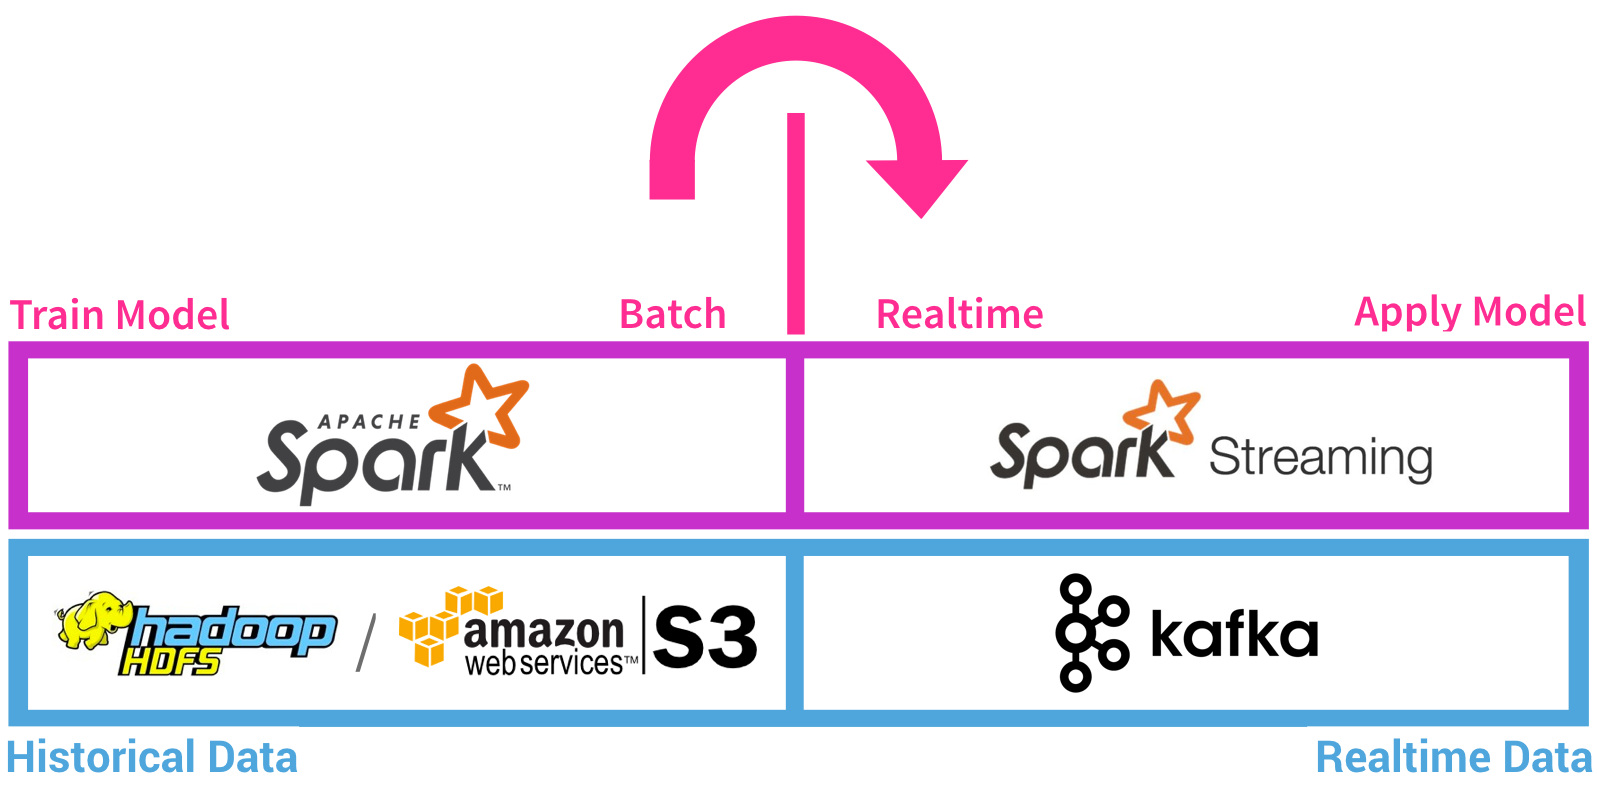

### Sending Prediction Requests to Kafka

In order to feed the prediction task and associated data to a Spark ML script deployed in batch, we need to generate Kafka events that indicate a prediction is needed. Our web application can easily do so using a form and an associated form controller that generates a prediction request as a Kafka message.

This is in contrast to the scikit-learn deployment via a web API, where the result was directly computed inside the web application. In the real world, this might correspond to a wide variety of circumstances, because any computation that takes longer than a fraction of a second is best deployed via Kafka. Kafka workers are precisely the place you want to handle a spike in load that would produce latency—Kafka is designed to handle such variable loads, and web applications are not.

In this case, a web application will emit a request for a prediction as a message in a Kafka topic. Then, a Spark Streaming minibatch will fetch today’s prediction requests and feed them to PySpark ML, which will create the predictions and store the results in a MongoDB collection. The prediction request page will then display the result of that prediction request’s prediction.

#### Setting up Kafka

Before proceeding, we’ll need to set up Kafka as we did in Chapter 2. You may want to refer to “Distributed Streams with Apache Kafka” to refresh yourself on Kafka, as this section is largely a rehash of that section. If you’ve already completed some of these steps and haven’t restarted your computer, you may be able to skip those steps you have already completed.

##### Create a Topic

Open another new console. We’ll use this one to run different Kafka commands, and then will leave it open as a console consumer for our prediction request topic.

Kafka messages are grouped into topics, so we need to create one before we can send messages through Kafka:

In [1]:
%%bash

../../kafka/bin/kafka-topics.sh \
    --create \
    --zookeeper localhost:2181 \
    --replication-factor 1 \
    --partitions 1 \
    --topic flight_delay_classification_request

Created topic "flight_delay_classification_request".


##### Verify our new prediction request topic

We can see the topic we created with the list topics command:

In [2]:
%%bash

../../kafka/bin/kafka-topics.sh --list --zookeeper localhost:2181

flight_delay_classification_request


We need to monitor this topic, so let’s run the console consumer on `flight_delay_classification_request` using a Terminal. Open a Terminal now and run:

```bash
cd
kafka/bin/kafka-console-consumer.sh \
    --bootstrap-server localhost:9092 \
    --topic flight_delay_classification_request \
    --from-beginning
```

That’s it. Now Kafka is ready to send and receive prediction requests, and we will see them as they occur! Now let’s set up our web application to emit requests.

### Feeding Kafka Recommendation Tasks from a Flask API

We will turn to kafka-python to act as Producer and emit Kafka events from our web application in [ch08/web/flask_predict.py](web/flask_predict.py).

First we need to import kafka-python and set up our KafkaProducer object, which will emit our events. We do so up top in our script, in case another controller needs Kafka. We also import the Python package uuid, which will create a unique ID for our prediction requests:

In [14]:
# Set up Kafka
from kafka import KafkaProducer, TopicPartition
producer = KafkaProducer(bootstrap_servers=['localhost:9092'],api_version=(0,10))
PREDICTION_TOPIC = 'flight_delay_classification_request'

import uuid

Next, we create a new API for prediction requests, based on the one we created for our batch requests, with a couple of changes. Instead of inserting requests into Mongo, we will emit JSON requests to our Kafka topic. These requests will each feature a Universally Unique Identifier (UUID) to identify them—a UUID is a random string long enough that it is very unlikely any other such string will overlap this one:

```python
# Make our API a post, so a search engine won't hit it
@app.route("/flights/delays/predict/classify_realtime", methods=['POST'])
def classify_flight_delays_realtime():
  
  # Define the form fields to process
  """POST API for classifying flight delays"""
  api_field_type_map = \
    {
      "DepDelay": float,
      "Carrier": str,
      "FlightDate": str,
      "Dest": str,
      "FlightNum": str,
      "Origin": str
    }
  
  # Fetch the values for each field from the form object
  api_form_values = {}
  for api_field_name, api_field_type in api_field_type_map.items():
    api_form_values[api_field_name] = request.form.get(
      api_field_name, type=api_field_type
    )
  
  # Set the direct values, which excludes Date
  prediction_features = {}
  for key, value in api_form_values.items():
    prediction_features[key] = value
  
  # Set the derived values
  prediction_features['Distance'] = predict_utils.get_flight_distance(
    client, api_form_values['Origin'],
    api_form_values['Dest']
  )
  
  # Turn the date into DayOfYear, DayOfMonth, DayOfWeek
  date_features_dict = predict_utils.get_regression_date_args(
    api_form_values['FlightDate']
  )
  for api_field_name, api_field_value in date_features_dict.items():
    prediction_features[api_field_name] = api_field_value
  
  # Add a timestamp
  prediction_features['Timestamp'] = predict_utils.get_current_timestamp()

  # Create a unique ID for this message
  unique_id = str(uuid.uuid4())
  prediction_features['UUID'] = unique_id
  
  message_bytes = json.dumps(prediction_features).encode()
  producer.send(PREDICTION_TOPIC, message_bytes)

  response = {"status": "OK", "id": unique_id}
  return json_util.dumps(response)
```

#### Running Our Prediction API

Now change directory to `ch08/web` and run the `predict_flask.py` script:

```bash
cd ch08/web
python ./predict_flask.py
```

We can test this API with curl and then by monitoring the console consumer we set up in the last section:

```bash
curl -XPOST 'http://localhost:5000/flights/delays/predict/classify_realtime' \
    -F 'DepDelay=5.0' \
    -F 'Carrier=AA' \
    -F 'FlightDate=2016-12-23' \
    -F 'Dest=ATL' \
    -F 'FlightNum=1519' \
    -F 'Origin=SFO' | jq
```

The request should show up in the console consumer, now with a UUID. That’s it! We’re producing prediction request events in Kafka.

## A FrontEnd for Generating Prediction Requests

Now we need a frontend for creating and displaying prediction requests and responses. This will look similar to the one we created for our scikit-learn regression web service earlier in this chapter, but with a new twist: a polling form.

### Polling requests and LinkedIn InMaps

This feature is different from those we’ve created before that used simple AJAX-style requests to POST a form and then display the content of the response. This form fits in between the two forms we created earlier in this chapter (the realtime form we created in “Pulling Our API into Our Product” that queried the scikit-learn model directly in our web application and immediately displayed its output on the page, and the form we created in “A frontend for generating prediction requests” that submitted a request for a prediction and didn’t expect an answer, because the output was displayed on another page after a batch process).

This time our form will expect a response from its submission request, but not an immediate response. It will first receive a response that indicates the prediction request has been received. This signals the client to send another request to a different endpoint to receive an answer. If the prediction isn’t ready, a response will indicate that the client should wait a suitable period before repeating its request. In the meantime, the client will display a “processing” message on the page. When a response is finally ready, it will be displayed on the page.

The figure below illustrates the frontend architecture of our application.

![ads2_0808.png](attachment:ads2_0808.png)

Many real products use this pattern for data processing and predictions. For instance, LinkedIn InMaps used this pattern. After user authentication via the LinkedIn API, the client would submit an asynchronous request for a network visualization for that user’s network to be produced. This would generate a request for a network image to be prepared. A “render farm” of servers would perform a force-directed layout for each network and would render the background image for each user’s map. When the map was prepared, the render worker created a record in a database. Meanwhile, the client would repeatedly poll a second endpoint, with a delay between each request, awaiting its map. A message on screen indicated the map was being created, until the map was finally transmitted and displayed. A social feature enabled users to share their maps, creating a viral loop that distributed the product.

![ads2_0809.png](attachment:ads2_0809.png)

We’ll be using a polling form to display flight delay predictions. This will require two endpoints and their corresponding controllers, and some simple JavaScript.

### A Controller for the Page

Check out [ch08/web/predict_flask.py](web/predict_flask.py), where we define a simple controller to serve the template for our prediction page:

```python
@app.route("/flights/delays/predict_kafka")
def flight_delays_page_kafka():
  """Serves flight delay prediction page with polling form"""
    
  form_config = [
    {'field': 'DepDelay', 'label': 'Departure Delay'},
    {'field': 'Carrier'},
    {'field': 'FlightDate', 'label': 'Date'},
    {'field': 'Origin'},
    {'field': 'Dest', 'label': 'Destination'},
  ]
  
  return render_template(
   'flight_delays_predict_kafka.html', form_config=form_config
  )
```

### An API Controller for Serving Prediction Responses

We also need a simple controller for serving the predictions when they are ready, signaled by their presence in MongoDB for any given UUID. This is simple CRUD work, which makes up the bulk of most consumer web applications:

```python
@app.route("/flights/delays/predict/classify_realtime/response/<unique_id>")
def classify_flight_delays_realtime_response(unique_id):
  """Serves predictions to polling requestors"""
  
  prediction = \
    client.agile_data_science.flight_delay_classification_response.find_one(
      {
        "id": unique_id
      }
    )
  
  response = {"status": "WAIT", "id": unique_id}
  if prediction:
    response["status"] = "OK"
    response["prediction"] = prediction
  
  return json_util.dumps(response)
```

We can verify that it works with curl:

In [32]:
%%bash

mongo agile_data_science --quiet --eval 'db.flight_delay_classification_response.drop()'
curl 'http://localhost:5000/flights/delays/predict/classify_realtime/response/EXAMPLE_UUID_g3t03qtq3t' | jq ''

true
{
  "status": "WAIT",
  "id": "EXAMPLE_UUID_g3t03qtq3t"
}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    51  100    51    0     0     51      0  0:00:01 --:--:--  0:00:01  3642


Now let’s insert a record for this UUID in Mongo:

In [33]:
%%bash

mongo agile_data_science --quiet --eval 'db.flight_delay_classification_response.insert(
  {
    id: "EXAMPLE_UUID_g3t03qtq3t", 
    prediction: {"test": "data"}
  }
)'

WriteResult({ "nInserted" : 1 })


In [34]:
%%bash

mongo agile_data_science --quiet --eval 'db.flight_delay_classification_response.find({"id": "EXAMPLE_UUID_g3t03qtq3t"})'

{ "_id" : ObjectId("5aeb0a617ef0893bca117867"), "id" : "EXAMPLE_UUID_g3t03qtq3t", "prediction" : { "test" : "data" } }


In [35]:
%%bash

curl 'http://localhost:5000/flights/delays/predict/classify_realtime/response/EXAMPLE_UUID_g3t03qtq3t'

{"status": "OK", "id": "EXAMPLE_UUID_g3t03qtq3t", "prediction": {"_id": {"$oid": "5aeb0a617ef0893bca117867"}, "id": "EXAMPLE_UUID_g3t03qtq3t", "prediction": {"test": "data"}}}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   175  100   175    0     0    175      0  0:00:01 --:--:--  0:00:01 29166


### Creating a Template with a Polling Form

The template for this controller is [ch08/web/templates/flight_delays_predict_kafka.html](web/templates/flight_delays_predict_kafka.html), which we copied from [ch08/web/templates/flight_delays_predict.html](web/templates/flight_delays_predict.html) and then edited in place. Open it up and follow along:

```html
{% extends "layout.html" %}
{% block body %}
  <!-- Navigation guide -->
  / <a href="/flights/delays/predict_kafka">
      Flight Delay Prediction with Kafka
    </a>

  <p class="lead" style="margin: 10px; margin-left: 0px;">
    
    Predicting Flight Delays with Kafka
  </p>

  <!-- Generate form from search_config and request args -->
  <form id="flight_delay_classification" 
         action="/flights/delays/predict/classify_realtime" 
         method="post">
    {% for item in form_config %}
      {% if 'label' in item %}
        <label for="{{item['field']}}">{{item['label']}}</label>
      {% else %}
        <label for="{{item['field']}}">{{item['field']}}</label>
      {% endif %}
        <input name="{{item['field']}}" 
                style="width: 36px; margin-right: 10px;" 
                value="">
        </input>
    {% endfor %}
    <button type="submit" class="btn btn-xs btn-default" style="height: 25px">
      Submit
    </button>
  </form>

  <div style="margin-top: 10px;">
      <p>Delay: <span id="result" style="display: inline-block;"></span></p>
  </div>

  
  <script src="/static/js/flight_delay_predict_polling.js"></script>
{% endblock %}
```

The template itself is simple; the real work happens in the JavaScript file, [ch08/web/static/flight_delay_predict_polling.js](web/static/flight_delay_predict_polling.js). Let’s go through it part by part. We’ve broken the task up into functions to keep things clean and simple.

As we’ve done before, we use jQuery.submit to attach a function to the submission of our HTML form. Within this function we process the form’s input and post it to the form’s endpoint at `/flights/delays/predict/classify_realtime`. Once a response is received indicating a successful prediction request has been submitted, we begin to poll a separate endpoint using a unique ID for the prediction request returned in the response:

```javascript
// Attach a submit handler to the form
$( "#flight_delay_classification" ).submit(function( event ) {

  // Stop form from submitting normally
  event.preventDefault();

  // Get some values from elements on the page
  var $form = $( this ),
    term = $form.find( "input[name='s']" ).val(),
    url = $form.attr( "action" );

  // Send the data using post
  var posting = $.post(
    url,
    $( "#flight_delay_classification" ).serialize()
  );
  
  // Submit the form and parse the response
  posting.done(function( data ) {
    response = JSON.parse(data);

    // If the response is OK, print a message to wait and start polling
    if(response.status == "OK") {
      $( "#result" ).empty().append( "Processing..." );

      // Every 1 second, poll the response URL until we get a response
      poll(response.id);
    }
  });
});
```

This polling is handled by the poll function. poll accepts the ID of the request and generates a URL for the response endpoint at `/flights/delays/predict/classify_realtime/response/`, which takes a slug at the end as a parameter. It submits an initial asynchronous GET request to this URL, and refers the response to the function `conditionalPoll`:

```javascript
// Poll the prediction URL
function poll(id) {
  var responseUrlBase = "/flights/delays/predict/classify_realtime/response/";
  console.log("Polling for request id " + id + "...");

  // Append the UUID to the URL as a slug argument
  var predictionUrl = responseUrlBase + id;

  $.ajax(
  {
    url: predictionUrl,
    type: "GET",
    complete: conditionalPoll
  });
}
```

`conditionalPoll` does what it sounds like—it either polls the endpoint again if the status of the response is WAIT, or it renders the response on the page via the function `renderPage` if the status is `OK`:

```javascript
// Decide whether to poll based on the response status
function conditionalPoll(data) {
  var response = JSON.parse(data.responseText);
  
  if(response.status == "OK") {
    renderPage(data);
  }
  else if(response.status == "WAIT") {
    setTimeout(function() {poll(response.id)}, 1000);
  }
}
```

`renderPage` is very simple. It draws the prediction response on the page, in the same place as the realtime, scikit-learn prediction frontend did:

```javascript
// Render the response on the page for splits:
// [-float("inf"), -15.0, 0, 30.0, float("inf")]
function renderPage(response) {

  var displayMessage;

  if(response.Prediction == 0) {
    displayMessage = "Early (15+ Minutes Early)";
  }
  else if(response.Prediction == 1) {
    displayMessage = "Slightly Early (0-15 Minute Early)";
  }
  else if(response.Prediction == 2) {
    displayMessage = "Slightly Late (0-30 Minute Delay)";
  }
  else if(response.Prediction == 3) {
    displayMessage = "Very Late (30+ Minutes Late)";
  }

  $( "#result" ).empty().append( displayMessage );
}
```

That wraps up the frontend for our Kafka-based prediction! Now let’s try things out.

## Making a Prediction Request

To test our page, visit [http://localhost:5000/flights/delays/predict_kafka](http://localhost:5000/flights/delays/predict_kafka) and open a JavaScript console. Now, enter some test data and submit the form. Be sure to fill out all the fields. You should see a waiting message and a request each second to the prediction response URL, as in the figure below.

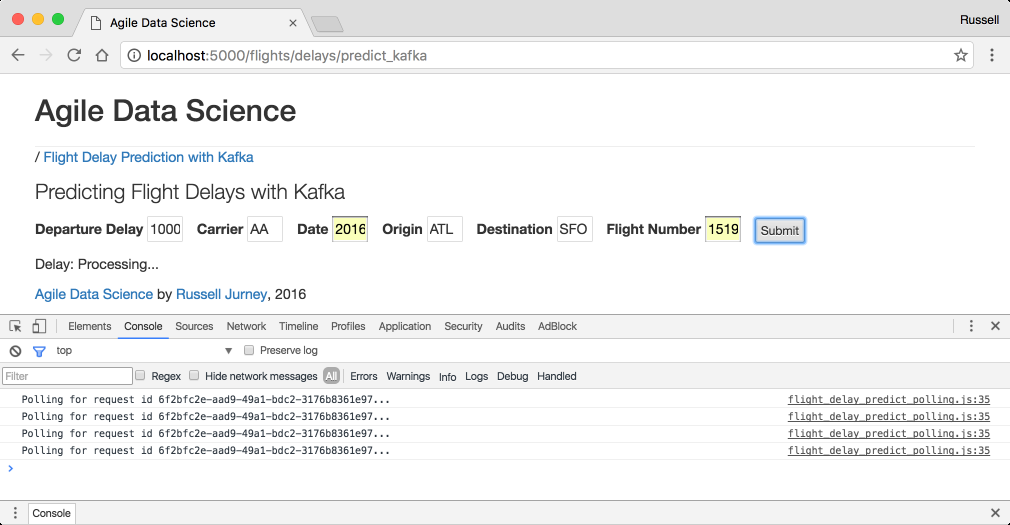

### Making Predictions in Spark Streaming

Now that we’ve created a frontend for making prediction requests via Kafka, as well as for displaying the result on the web, we need to finish up the middle where PySpark Streaming processes Kafka events and inserts the result in Mongo for the frontend to render. Note that you can learn more about deploying PySpark Streaming in the Spark Streaming Programming Guide.

Check out [ch08/make_predictions_streaming.py](make_predictions_streaming.py). We initialize the system in a similar way as we do in batch, albeit with a StreamingContext as well as a SparkSession. So long as they both come from the same SparkContext, they will play well together (although, as we will see, Spark Streaming is primarily RDD-based).

Note that our main function only takes one argument this time, the base_path. The date isn’t needed, as our script will process any Kafka event that it sees.

In order to run a Spark Streaming script, we have to include the Spark Streaming package, which currently goes by the name `org.apache.spark:spark-streaming-kafka-0-8_2.11:2.1.0` (the version may have changed by the time you’re reading this). We can achieve this at the command line during development using the PySpark console:

```bash
PYSPARK_DRIVER_PYTHON=ipython pyspark --packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.1.0
```

However, to make our script command-line executable, we must use findspark to do the import, via findspark.add_packages. We also need to initialize pymongo-spark, as we’ll be storing results directly in Mongo. In contrast with batch, with Spark Streaming it is necessary to do both things at once (make the prediction and store the result in Mongo):

```python
#!/usr/bin/env python

import sys, os, re
import json
import datetime, iso8601

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Row
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils

# Save to Mongo
from bson import json_util
import pymongo_spark
pymongo_spark.activate()

def main(base_path):

  APP_NAME = "make_predictions_streaming.py"

  # Process data every 10 seconds
  PERIOD = 10
  BROKERS = 'localhost:9092'
  PREDICTION_TOPIC = 'flight_delay_classification_request'
  
  try:
    sc and ssc
  except NameError as e:
    import findspark

    # Add the streaming package and initialize
    findspark.add_packages(["org.apache.spark:spark-streaming-kafka-0-8_2.11:2.1.0"])
    findspark.init()
    
    import pyspark
    import pyspark.sql
    import pyspark.streaming
  
    conf = SparkConf().set("spark.default.parallelism", 1)
    sc = SparkContext(appName="Agile Data Science: PySpark Streaming 'Hello, World!'", conf=conf)
    ssc = StreamingContext(sc, PERIOD)
    spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()
```

The code for loading the models comes directly from [ch08/make_predictions.py](make_predictions.py), and I will not repeat it here. We load the models in main before doing anything else. The beauty of Spark Streaming is that you can reuse code from Spark in batch mode, enabling you to prototype there or create common libraries of code between batch and realtime systems.

Once we load our models, we need to fetch messages from Kafka using `KafkaUtils.createDirectStream`:

```python
  #
  # Process Prediction Requests in Streaming
  #
  stream = KafkaUtils.createDirectStream(
    ssc,
    [PREDICTION_TOPIC],
    {
      "metadata.broker.list": BROKERS,
      "group.id": "0",
    }
  )
```

Since our messages are JSON, we’ll need to parse them. The pprint method lets us take a peek at our data as it flows through Spark Streaming:

```python
  object_stream = stream.map(lambda x: json.loads(x[1]))
  object_stream.pprint()
```

At this point our prediction requests are `RDDs` of Python dicts. The models we’ve created work with `DataFrames`, so we need to convert them. In order to do this, we first need to create `spark.sql.Rows` out of the dicts. In doing so, we’ll need to convert our ISO 8601 date strings to datetime objects using `iso8601.parse_date`. As before, we pprint the result:

```python
  row_stream = object_stream.map(
    lambda x: Row(
      FlightDate=iso8601.parse_date(x['FlightDate']),
      Origin=x['Origin'],
      Distance=x['Distance'],
      DayOfMonth=x['DayOfMonth'],
      DayOfYear=x['DayOfYear'],
      UUID=x['UUID'],
      DepDelay=x['DepDelay'],
      DayOfWeek=x['DayOfWeek'],
      FlightNum=x['FlightNum'],
      Dest=x['Dest'],
      Timestamp=iso8601.parse_date(x['Timestamp']),
      Carrier=x['Carrier']
    )
  )
  row_stream.pprint()
```

Our next step is not intuitive, because it is a single step where all the work happens. This doesn’t seem to jive with the dataflow orientation of Spark. However, in Spark Streaming you often employ `DStream.foreachRDD` to perform a long series of operations on the RDD within the DStream. In this sense, Streaming really sits on top of other Spark abstractions, enabling you to use normal Spark techniques on streaming data.

Let’s start with the call itself, a one-liner:

```python
  # Do the classification and store to Mongo
  row_stream.foreachRDD(classify_prediction_requests)
```

Note that we define this function within our main function, so that it will have access to the models we’ve loaded there. We might have passed them in as arguments, but that’s ungainly. The downside of defining the function inside main is that it isn’t importable from outside by another script.

`classify_prediction_requests` takes an RDD as its argument, and then employs SparkSession.createDataFrame to convert the Row we prepared into a full-blown DataFrame. As with the batch version of this script, we need to set up the schema first, this time with a UUID field. Once the DataFrame is created, we can employ DataFrame.show to see what is going on:

```python
  def classify_prediction_requests(rdd):
  
    from pyspark.sql.types import StringType, IntegerType, DoubleType, DateType, TimestampType
    from pyspark.sql.types import StructType, StructField
  
    prediction_request_schema = StructType([
      StructField("Carrier", StringType(), True),
      StructField("DayOfMonth", IntegerType(), True),
      StructField("DayOfWeek", IntegerType(), True),
      StructField("DayOfYear", IntegerType(), True),
      StructField("DepDelay", DoubleType(), True),
      StructField("Dest", StringType(), True),
      StructField("Distance", DoubleType(), True),
      StructField("FlightDate", DateType(), True),
      StructField("FlightNum", StringType(), True),
      StructField("Origin", StringType(), True),
      StructField("Timestamp", TimestampType(), True),
      StructField("UUID", StringType(), True),
    ])
    
    prediction_requests_df = spark.createDataFrame(rdd, schema=prediction_request_schema)
    prediction_requests_df.show()
```

As we did in batch, we need to derive the Route field from the `Origin` and `Dest` fields:

```python
    #
    # Add a Route variable to replace FlightNum
    #

    from pyspark.sql.functions import lit, concat
    prediction_requests_with_route = prediction_requests_df.withColumn(
      'Route',
      concat(
        prediction_requests_df.Origin,
        lit('-'),
        prediction_requests_df.Dest
      )
    )
    prediction_requests_with_route.show(6)
```

Now that we have a DataFrame, we simply repeat the prediction code from ch08/make_preditions.py, which results in a prediction within a DataFrame. Again we take a peek at the output with show, just as we would in batch:

```python
    # Vectorize string fields with the corresponding pipeline for that column
    # Turn category fields into categoric feature vectors, then drop intermediate fields
    for column in ["Carrier", "Origin", "Dest", "Route"]:
      string_indexer_model = string_indexer_models[column]
      prediction_requests_with_route = string_indexer_model.transform(prediction_requests_with_route)
  
    # Vectorize numeric columns: DepDelay, Distance and index columns
    final_vectorized_features = vector_assembler.transform(prediction_requests_with_route)
    
    # Inspect the vectors
    final_vectorized_features.show()
  
    # Drop the individual index columns
    index_columns = ["Carrier_index", "Origin_index", "Dest_index", "Route_index"]
    for column in index_columns:
      final_vectorized_features = final_vectorized_features.drop(column)
  
    # Inspect the finalized features
    final_vectorized_features.show()
  
    # Make the prediction
    predictions = rfc.transform(final_vectorized_features)
  
    # Drop the features vector and prediction metadata to give the original fields
    predictions = predictions.drop("Features_vec")
    final_predictions = predictions.drop("indices").drop("values").drop("rawPrediction").drop("probability")
  
    # Inspect the output
    final_predictions.show()
```

Finally, we need to convert the predictions DataFrame into RDDs, because pymongo-spark doesn’t work with DataFrames, it works with RDDs composed of dicts (and not even `pyspark.sql.Rows`). Also, the call to `saveToMongoDB` will fail if the RDD is empty, so we need to only saveToMongoDB if there are results:

```python
    # Store to Mongo
    if final_predictions.count() > 0:
      final_predictions.rdd.map(lambda x: x.asDict()).saveToMongoDB(
        "mongodb://localhost:27017/agile_data_science.flight_delay_classification_response"
      )
```

Whew! That’s it. If everything is working as expected, our predictions will be routed from Kafka through Spark ML and back into MongoDB.

## Testing the Entire System

Now we’re about to have what I hope is a great deal of fun! We get to test the system from end to end. But before doing so, I want to take a moment and review what we’ve done.

### OVERALL SYSTEM SUMMARY

We collected public data from the web describing 5.4 million flights of commercial airlines. We got to know that data through exploratory data analysis, interactive visualization, and search. This prepared us for the process by which we turned the flights into training data for a statistical model to predict flight delays using Spark, a tool that can process data at any scale. Then we set up a web frontend that generated prediction requests and sent them to a distributed queue in the form of Kafka, which again can handle data of any scale. Spark Streaming let us use the models we prepared in batch to turn Kafka messages into predictions in real time, the results of which we stored in MongoDB, where our web frontend could access them. Finally, the predictions were displayed to the user.

### RUBBER MEETS ROAD
Okay, let’s go! To try things out, run our script from bash:

```bash
python ch08/make_predictions_streaming.py .
```

The output is voluminous, but the key parts correspond to our pprints and shows. At this point you should see the empty output that follows (truncated to fit the page):

Now, visit [http://localhost:5000/flights/delays/predict_kafka](http://localhost:5000/flights/delays/predict_kafka) and, for fun, open the JavaScript console. Enter a nonzero departure delay, an ISO-formatted date (I used 2016-12-25, which was in the future at the time I was writing this), a valid carrier code (use AA or DL if you don’t know one), an origin and destination (my favorite is ATL → SFO), and a valid flight number (e.g., 1519), and hit Submit. Watch the debug output in the JavaScript console as the client polls for data from the response endpoint at /flights/delays/predict/classify_realtime/response/.

Quickly switch windows to your Spark console. Within 10 seconds, the length we’ve configured of a minibatch, you should see something like the following:

```sql
-------------------------------------------
Time: 2016-12-20 18:06:50
-------------------------------------------
{
 'Dest': 'ORD', 
 'DayOfYear': 360, 
 'FlightDate': '2016-12-25', 
 'Distance': 606.0, 
 'DayOfMonth': 25, 
 'UUID': 'a01b5ccb-49f1-4c4d-af34-188c6ae0bbf0', 
 'FlightNum': '2010', 
 'Carrier': 'AA', 
 'DepDelay': -100.0, 
 'DayOfWeek': 6, 
 'Timestamp': '2016-12-20T18:06:45.307114', 
 'Origin': 'ATL'
 }

-------------------------------------------
Time: 2016-12-20 18:06:50
-------------------------------------------
Row(Carrier='AA', DayOfMonth=25, DayOfWeek=6, DayOfYear=360, DepDelay=-100.0, 
Dest='ORD', Distance=606.0, FlightDate=datetime.datetime(2016, 
12, 25, 0, 0, tzinfo=<iso8601.Utc>), FlightNum='2010', 
Origin='ATL', Timestamp=datetime.datetime(2016, 12, 20, 18, 
6, 45, 307114, tzinfo=<iso8601.Utc>), 
UUID='a01b5ccb-49f1-4c4d-af34-188c6ae0bbf0')

+-------+----------+---------+---------+
|Carrier|...|                UUID|
+-------+----------+---------+---------+
|     AA|...|a01b5ccb-49f1-4c4...|
+-------+----------+---------+---------+

+-------+----------+---------+---------+
|Carrier|...|        Features_vec|
+-------+----------+---------+---------+
|     AA|...|(8009,[2,38,51,34...|
+-------+----------+---------+---------+

+-------+----------+---------+---------+
|Carrier|...|        Features_vec|
+-------+----------+---------+---------+
|     AA|...|(8009,[2,38,51,34...|
+-------+----------+---------+---------+

+-------+----------+---------+---------+
|Carrier|...|Prediction|
+-------+----------+---------+---------+
|     AA|...|       0.0|
+-------+----------+---------+---------+
```

### PAYDIRT!

Switching back to your browser, you should see the prediction result proudly displayed, as in Figure 8-11. Pretty amazing to watch, yeah!? As I write this I am submitting requests over and over, and I am amazed at how it all fits together, and how this same code might work with a petabyte of data on a large Spark cluster with hundreds of web servers to match. The point of all the trouble we’ve gone through in this book is to build applications that will scale all the way up to that level. I hope this application and the book describing it serve as an example you can learn from and extend.

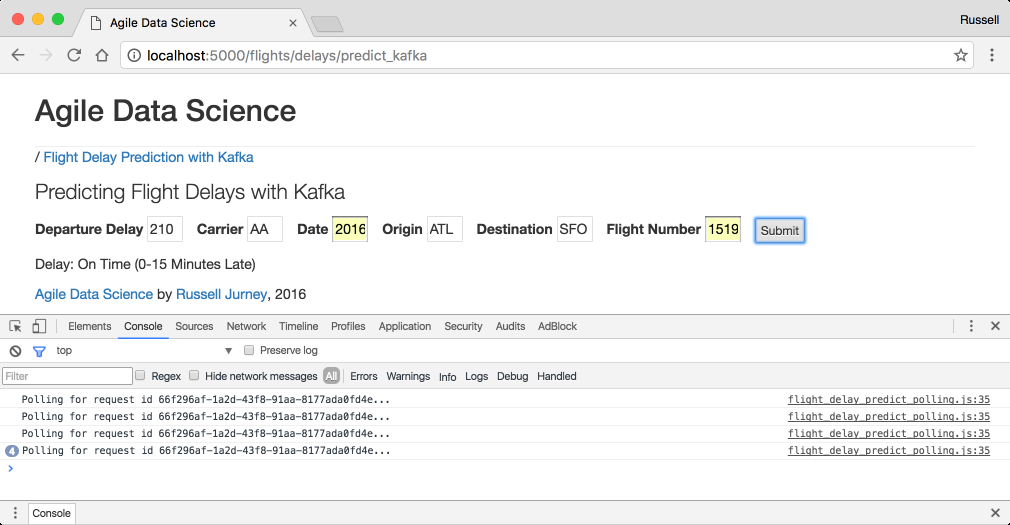

## Conclusion

In this chapter we’ve taken the predictive model we built in the last chapter and integrated it into a real product facing the web. We did so in three different ways: in real time using scikit-learn as a web service, in batch using Spark and Airflow, and in “sub-real time” using Kafka and Spark Streaming. I hope you can use what we’ve covered in this chapter to deploy your own models as full-blown predictive systems in new data products!

I would very much like to hear how you’ve used Agile Data Science and the example in this chapter to build your own products, and I’d like to help you do so. Don’t hesitate to reach out. You can email me personally at russell.jurney@gmail.com, or sign up for the Agile Data Science email list, agile-data-science@googlegroups.com.

Now we turn to improving the model we’ve created. Once a model meets reality in the form of a product and catches on, product development often turns into a relentless drive to improve that model in as much as it impacts the bottom line. I hope your products have this “problem,” and so this is what we focus on next.

In [8]:
%%bash

mongo agile_data_science --quiet --eval 'db.flight_delay_classification_response.drop()'
mongo agile_data_science --quiet --eval 'db.flight_delay_classification_response.insert(
  {
    id: "", 
    prediction: {Prediction: 0}
  }
)'
mongo agile_data_science --quiet --eval 'db.flight_delay_classification_response.find()'

true
WriteResult({ "nInserted" : 1 })
{ "_id" : ObjectId("5aeb150778264869c55561ff"), "id" : "78639548-4822-4c26-857b-afe80246e6d8", "prediction" : { "Prediction" : 0 } }
